### <b>XGBoost (Extreme Gradient Boosting)</b>
A powerful machine learning algorithm that is commonly used for regression and classification tasks.<br> 
It is an ensemble method that combines the predictions of multiple decision trees,<br>
and it uses a gradient boosting technique to improve the accuracy of the model.<br>
XGBoost is often used in data science competitions and has a reputation for being one of the most effective algorithms available.
<br><br>
<b>Pros:</b>
<ul>
<li>Highly accurate and powerful</li>
<li>Handles missing values well</li>
<li>Parallel Processing</li>
<li>Regularization: Has built in L1 (Lasso) and L2 (Ridge) regularization</li>
<li>Performs well with large datasets</li>
<li>Can handle a variety of data types (e.g., categorical, numerical)</li>
<li>Has strong community suport and is widely used in industry and competitions</li>
</ul>

<b>Cons:</b>
<ul>
<li>Can be computationally expensive and slow to train</li>
<li>Requires careful hyperparameter tuning</li>
<li>May overfit if not regularized properly</li>
<li>Can be difficult to interpret</li>
</ul>

<br>
<b>When to use:</b>
<ul>
  <li>When you have a large dataset, and you want a highly accurate model</li>
  <li>Large Number of observations in training data</li>
  <li>Number of features is smaller then number of observations in training data</li>
  <li>When the model performance metrics are to be considered</li>
</ul>
<br>
<b>When not to use:</b>
<ul>
<li>number of observations in training data is significantly smaller than the number of features.</li>
<li>Computer vision, image recognition and natural language processing</li>
<li>Regression tasks that involve predicting a continuous output.</li>
</ul>
<br><br>

### <b>SVR (Support Vector Regression)</b>
Support Vector Regression (SVR) is a type of regression algorithm that is based on Support Vector Machines<br> (SVMs). SVR assumes that the data is linearly separable and tries to find the hyperplane that best fits<br> the data. It is often used when the data has a non-linear relationship, and it is useful for handling<br> large datasets.

<br>
<b>Pros:</b>
<ul>
  <li>Can handle non-linear relationships and large datasets</li>
  <li>Performs well in high-dimensional feature spaces</li>
  <li>Can handle both regression and classification tasks</li>
  <li>Has good theoretical support and is well-understood</li>
</ul>

<b>Cons:</b>
<ul>
  <li>Can be sensitive to hyperparameters and requires careful tuning</li>
  <li>Can be slow to train, especially with large datasets</li>
  <li>May not perform well with noisy data or outliers</li>
  <li>Can be difficult to interpret</li>
</ul>

<br>

<b>When to use:</b>
<ul>
  <li>When you have a large dataset, and you want a highly accurate model</li>
  <li>Number of features is smaller then number of observations in training data</li>
  <li>When the model performance metrics are to be considered</li>
</ul>

<br>

<b>When not to use:</b>
<ul>
  <li>When you have a small dataset or when you need to interpet the model</li>
  <li>Computer vision, image recognition and natural language processing</li>
  <li>Regression tasks that involve predicting a continuous output.</li>
</ul>

<br><br>

### <b>KNeighbors Regessor</b>
K-Nearest Neighbors Regression (KNeighborsRegressor) is a simple algorithm that is based on the idea of<br> finding the k-nearest neighbors to a given data point and using their values to make a prediction.<br> 
It assumes that similar data points will have similar outputs and is often used when there is a small<br> amount of data available.

<br>
<b>Pros:</b>
<ul>
<li>Simple and easy to understand</li>
<li>Works well with small datasets</li>
<li>Can handle non-linear relationships</li>
<li>Doesn't make any assumptions about the underlying data distribution</li>
</ul>

<b>Cons:</b>
<ul>
<li>Can be computationally expensive with large datasets</li>
<li>Requires careful choice of k (number of neighbors)</li>
<li>Can be sensitive to the distance metric used</li>
<li>Can perform poorly with noisy data or outliers</li>
</ul>

<br>
<b>When to use:</b>
<ul>
  <li>When you have a small dataset and want a simple model</li>
</ul>
<br>
<b>When not to use:</b>
<ul>
<li>When you have a large dataset or when the dataset is noisy</li>
</ul>
<br><br>

### <b>Random Forest Regressor</b>
Random Forest Regression (RandomForestRegressor) is an ensemble algorithm that is based on decision trees.<br> It creates a large number of decision trees and then combines their predictions to make a final prediction. 

<br>
<b>Pros:</b>
<ul>
  <li>Handles non-linear relationships and large datasets well</li>
  <li>Performs well in high-dimensional feature spaces</li>
  <li>Doesn't make many assumptions about the data distribution</li>
  <li>Can handle both regression and classification tasks</li>
  <li>Can provide feature importance estimates</li>
</ul>

<b>Cons:</b>
<ul>
  <li>Can be computationally expensive with large datasets</li>
  <li>Can overfit if not regularized properly</li>
  <li>Can be difficult to interpret</li>
  <li>Can struggle with data that has strong class imbalances</li>
</ul>

<br>

<b>When to use:</b>
<ul>
  <li>When there are many features in the data and when the data has a non-linear relationship.</li>
  <li>When the data has a non-linear relationship.</li>
</ul>

<br>

<b>When not to use:</b>
<ul>
  <li>When the data is linearly separable</li>
</ul>
<br><br>

### <b>Linear Regession</b>
Linear Regression is a simple algorithm that assumes that there is a linear relationship between the input<br> variables and the output variable. It is often used when the data has a linear relationship, and it is useful<br> for understanding the relationship between variables. 

<br>
<b>Pros:</b>
<ul>
  <li>Simple and easy to understand</li>
  <li>Fast to train</li>
  <li>Provides clear coefficients that can be interpreted</li>
  <li>Performs well when the relationship between input and output is linear</li>
</ul>

<b>Cons:</b>
<ul>
  <li>Assumes a linear relationship between input and output</li>
  <li>Can be sensitive to outliers and noisy data</li>
  <li>Doesn't handle interactions between features well</li>
  <li>Can overfit with high-dimensional feature spaces</li>
</ul>

<br>

<b>When to use:</b>
<ul>
  <li>When you have a linear relationship between the input variables and the output variable.</li>
</ul>

<br>

<b>When not to use:</b>
<ul>
  <li>When you have a non-linear relationship between the input variables and the output variable</li>
</ul>
<br><br>

### <b>Ridge Regression</b>
Ridge Regression is a variant of linear regression that is used when the data has multicollinearity<br> (i.e., when there is a high correlation between the input variables). It introduces a penalty term to the<br> objective function that helps to reduce the impact of multicollinearity.

<br>
<b>Pros:</b>
<ul>
  <li>Handles multicollinearity well</li>
  <li>Regularizes the model and reduces the impact of noise and outliers</li>
  <li>Has a clear regularization parameter that can be tuned</li>
</ul>

<b>Cons:</b>
<ul>
  <li>Assumes a linear relationship between input and output</li>
  <li>Can underfit if the regularization parameter is set too high</li>
  <li>Can be difficult to interpret</li>
  <li>Doesn't handle interactions between features well</li>
</ul>

<br>

<b>When to use:</b>
<ul>
  <li>When you have multicollinearity in your dataset</li>
</ul>

<br>

<b>When not to use:</b>
<ul>
  <li>When there is no multicollinearity in the dataset</li>
</ul>
<br><br>

### <b>Lasso Regression</b>
Lasso Regression is another variant of linear regression that is used to handle multicollinearity.<br> It also introduces a penalty term to the objective function, but it uses a different approach to reduce<br> the impact of multicollinearity.

<br>
<b>Pros:</b>
<ul>
  <li>Handles multicollinearity well</li>
  <li>Regularizes the model and reduces the impact of noise and outliers</li>
  <li>Can perform feature selection by shrinking coefficients to zero</li>
  <li>Has a clear regularization parameter that can be tuned</li>
</ul>

<b>Cons:</b>
<ul>
  <li>Assumes a linear relationship between input and output</li>
  <li>Can underfit if the regularization parameter is set too high</li>
  <li>Can be sensitive to the scaling of the input features</li>
  <li>Doesn't handle interactions between features well</li>
</ul>

<br>

<b>When to use:</b>
<ul>
  <li>When you have multicollinearity and want a more interpretable model</li>
</ul>

<br>

<b>When not to use:</b>
<ul>
  <li>When there is no multicollinearity in the dataset</li>
</ul>
<br><br>

### <b>Elastic Net Regression</b>
Elastic Net Regression is a hybrid of Ridge and Lasso regression. It combines the penalty terms of both algorithms to handle multicollinearity.

<br>
<b>Pros:</b>
<ul>
  <li>Handles multicollinearity well</li>
  <li>Regularizes the model and reduces the impact of noise and outliers</li>
  <li>Can perform feature selection by shrinking coefficients to zero</li>
  <li>Balances the strengths of Ridge and Lasso regularization</li>
</ul>

<b>Cons:</b>
<ul>
  <li>Assumes a linear relationship between input and output</li>
  <li>Can underfit if the regularization parameter is set too high</li>
  <li>Can be sensitive to the scaling of the input features</li>
  <li>Doesn't handle interactions between features well</li>
</ul>

<br>

<b>When to use:</b>
<ul>
  <li>When you have multicollinearity and want to balance between Ridge and Lasso</li>
</ul>

<br>

<b>When not to use:</b>
<ul>
  <li>Small or simple datasets: ElasticNet regression requires a sufficiently large dataset to train on, and may not perform as well on small datasets or datasets with very few features. </li>
  <li>If the data contains many outliers or high leverage points</li>
</ul>


In [1]:
import re
from time import time

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

import xgboost as xgb
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import LeaveOneOut

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ParameterSampler, KFold
from sklearn.metrics import r2_score, mean_squared_error

from scipy.stats import uniform

In [2]:
sns.set(font_scale=1.5)

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 200
pd.options.display.max_colwidth = None

In [3]:
df = pd.read_excel('Data/Real_Estate Data.xlsx')

### Preliminary exploration

In [4]:
display(df.head(), df.shape)

,Sr. No.,Location,Sub-Area,Propert Type,Property Area in Sq. Ft.,Price in lakhs,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
0,1,"Pune, Maharashtra, India",Bavdhan,1 BHK,492,39,3.9,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,2,"Pune, Maharashtra, India",Bavdhan,2 BHK,774,65,6.5,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2,3,"Pune, Maharashtra, India",Bavdhan,3 BHK,889,74,7.4,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3,4,"Pune, Maharashtra, India",Bavdhan,3 BHK Grand,1018,89,8.9,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4,5,"Pune, Maharashtra, India",Mahalunge,2BHK,743,74,7.4,Godrej Properties,Godrej Hills retreat,100.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes


(200, 17)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Sr. No.                           200 non-null    int64  
 1   Location                          200 non-null    object 
 2   Sub-Area                          200 non-null    object 
 3   Propert Type                      200 non-null    object 
 4   Property Area in Sq. Ft.          200 non-null    object 
 5   Price in lakhs                    200 non-null    object 
 6   Price in Millions                 199 non-null    float64
 7   Company Name                      200 non-null    object 
 8   TownShip Name/ Society Name       200 non-null    object 
 9   Total TownShip Area in Acres      51 non-null     float64
 10  ClubHouse                         200 non-null    object 
 11  School / University in Township   200 non-null    object 
 12  Hospital

In [6]:
df.rename(columns={'Propert Type': 'Property Type'}, inplace=True)

In [7]:
df['Property Type'].unique()

array(['1 BHK', '2 BHK', '3 BHK', '3 BHK Grand', '2BHK', '3BHK', '4BHK',
       '5BHK', '6BHK', '1BHK', 'shop', '2 bhk', '2bhk ', '3  bhk ',
       '3 bhk', '2bhk', '2.5 BHK', '3 BHK ', '4 bhk', '1 bhk', '2.5 bhk',
       '1bhk', '3bhk', '3.5bhk', '3.5 bhk', '3bhk ', '2+2 bhk', '3+2bhk ',
       '2 bhk ', '5 bhk', '1bhk ', '4.5bhk', '4bhk'], dtype=object)

In [8]:
df = df[df['Property Type'] != 'shop']
df.shape

(199, 17)

#### property type needs cleaning

In [9]:
df['Property Area in Sq. Ft.'].unique()

array([492, 774, 889, 1018, 743, 975, '877 to 912', '1077 to 1272', 905,
       1125, 1644, 2220, '662 to 845', '890 to 1212', 423, 665,
       '792 to 965', 462, 666, 750, 1030, 446, 796, 842, 865, 902, 1154,
       872, 934, 1088, 1109, 1163, 1419, 1485, 684, 990, 882, 1103, 543,
       '801 to 1125', '1272 to 2138', 320, 473, 581, 790, 820, 989, 1003,
       1182, 1579, 491, 659, 732, 809, 460, 734, 753, 675, 917, 670, 740,
       847, 936, 1032, 1698, 2267, 725, 731, 744, 923, 930, 792, 1180,
       860, 988, 1093, 456, 644, 785, 1060, 113, 664, 673, 682, 698, 1239,
       1315, 1388, 1463, 1671, 1687, 575, 751, 761, 871, 1166, 1206, 1272,
       1279, 646, 717, 436, 637, 642, 655, 668, 810, 735, 783, 805, 1074,
       1111, 535, 947, 697, 711, 980, 1400, 1772, 1662, 705, 726, 793,
       904, 1168, 1189, 479, 693, 808, 1086, 844, 873, 606, 611, 626, 691,
       835, 854, 715, '624 to 761', 968, 996, 1038, 489, 598, 616, 692,
       867, 908, 1624, 2043, 727, '561 to 902', '1056 to

#### In property Area column there is a mix of integers and strings the string are written like this<br> 500 to 600 for this we will compute the mean value and convert all of the data to floats.

In [10]:
def split_sum(e, flag=True):
    try:
        e = str(e).lower()
        e = re.sub(r'[,.;@#?!&$+]+\ *', ' ', e)
        e = re.sub(r'[a-z]+', ' ', e)
        e = re.sub(r'\s\s', '', e)

        s2list = e.strip().split()
        sumList = sum(float(e) for e in s2list)

        e_norm = sumList if flag else sumList / len(s2list)
        return e_norm    
    
    except:
        return np.nan
    
def normalize_props(df):
    data = df.copy()
    data['Property Type'] = data['Property Type'].apply(split_sum)
    data['Property Area in Sq. Ft.'] = data['Property Area in Sq. Ft.'].apply(lambda x: split_sum(x, False))

    return data

In [11]:
df_norm = normalize_props(df)

In [12]:
df_norm['Property Type'].unique()

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

In [13]:
df_norm['Property Area in Sq. Ft.'].unique()

array([ 492. ,  774. ,  889. , 1018. ,  743. ,  975. ,  894.5, 1174.5,
        905. , 1125. , 1644. , 2220. ,  753.5, 1051. ,  423. ,  665. ,
        878.5,  462. ,  666. ,  750. , 1030. ,  446. ,  796. ,  842. ,
        865. ,  902. , 1154. ,  872. ,  934. , 1088. , 1109. , 1163. ,
       1419. , 1485. ,  684. ,  990. ,  882. , 1103. ,  543. ,  963. ,
       1705. ,  320. ,  473. ,  581. ,  790. ,  820. ,  989. , 1003. ,
       1182. , 1579. ,  491. ,  659. ,  732. ,  809. ,  460. ,  734. ,
        753. ,  675. ,  917. ,  670. ,  740. ,  847. ,  936. , 1032. ,
       1698. , 2267. ,  725. ,  731. ,  744. ,  923. ,  930. ,  792. ,
       1180. ,  860. ,  988. , 1093. ,  456. ,  644. ,  785. , 1060. ,
        113. ,  664. ,  673. ,  682. ,  698. , 1239. , 1315. , 1388. ,
       1463. , 1671. , 1687. ,  575. ,  751. ,  761. ,  871. , 1166. ,
       1206. , 1272. , 1279. ,  646. ,  717. ,  436. ,  637. ,  642. ,
        655. ,  668. ,  810. ,  735. ,  783. ,  805. , 1074. , 1111. ,
      

In [14]:
df_norm.dtypes

Sr. No.                               int64
Location                             object
Sub-Area                             object
Property Type                       float64
Property Area in Sq. Ft.            float64
Price in lakhs                       object
Price in Millions                   float64
Company Name                         object
TownShip Name/ Society Name          object
Total TownShip Area in Acres        float64
ClubHouse                            object
School / University in Township      object
Hospital in TownShip                 object
Mall in TownShip                     object
Park / Jogging track                 object
Swimming Pool                        object
Gym                                  object
dtype: object

### Cleaning the outliers

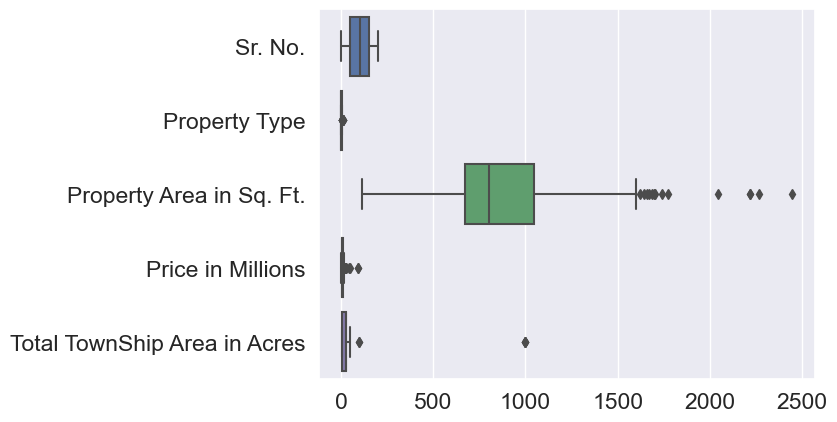

In [15]:
sns.boxplot(data=df_norm, orient='h')
plt.show()

In [16]:
def compute_upper(df_col, up=True):
    iqr = df_col.quantile(.75) - df_col.quantile(.25)

    if up:
        return df_col.quantile(.75) + 1.5 * iqr
    return df_col.quantile(.25) - 1.5 * iqr

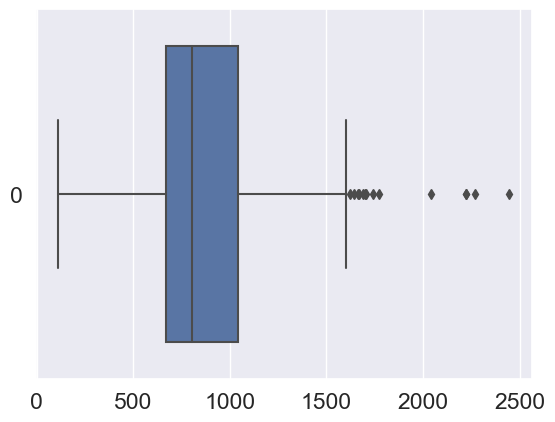

In [17]:
sns.boxplot(data=df_norm['Property Area in Sq. Ft.'], orient='h')
plt.show()

In [18]:
x_pa = df_norm['Property Area in Sq. Ft.']
pa_up_lim = compute_upper(x_pa)
df_norm[x_pa > pa_up_lim]

,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in lakhs,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
10,11,"Pune, Maharashtra, India",Ravet,4.0,1644.0,135,13.5,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
11,12,"Pune, Maharashtra, India",Ravet,5.0,2220.0,188,18.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
12,13,"Pune, Maharashtra, India",Ravet,6.0,2220.0,188,18.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
41,42,"Pune, Maharashtra, India",Keshav Nagar,3.0,1705.0,Null,NaN,Mantra Properties,Mantra Insignia,NaN,Yes,No,No,No,Yes,Yes,Yes
67,68,"Pune, Maharashtra, India",kayani nagar,3.0,1698.0,249,24.9,sagitarius ecospaces llp,bluegrass residences,NaN,yes,no,no,no,yes,yes,yes
68,69,"Pune, Maharashtra, India",kayani nagar,4.0,2267.0,460,46.0,sagitarius ecospaces llp,bluegrass residences,NaN,yes,no,no,no,yes,yes,yes
96,97,"Pune, Maharashtra, India",NIBM,8.0,1671.0,211,21.1,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes
97,98,"Pune, Maharashtra, India",NIBM,8.0,1687.0,213,21.3,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes
128,129,"Pune, Maharashtra, India",Hinjewadi,5.0,1772.0,177,17.7,Shapoorji Paloonji,Sensorium,NaN,yes,no,no,no,yes,yes,yes
131,132,"Pune, Maharashtra, India",hadapsar,5.0,1662.0,130,13.0,Wellwisher Apartments,kiarah terrazo,NaN,no,no,no,no,yes,no,no


#### we won't consider these as outliers seeing that the larger the property area the more bedrooms they have

<Axes: >

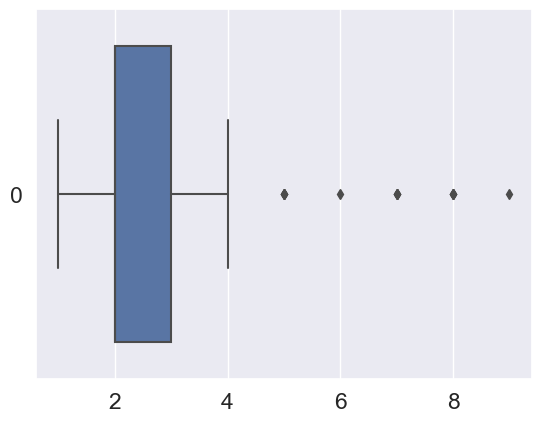

In [19]:
sns.boxplot(data=df_norm['Property Type'], orient='h')

In [20]:
x_prt = df_norm['Property Type']
prt_up_lim = compute_upper(x_prt)
df_norm[x_prt > prt_up_lim]

,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in lakhs,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
11,12,"Pune, Maharashtra, India",Ravet,5.0,2220.0,188,18.800,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
12,13,"Pune, Maharashtra, India",Ravet,6.0,2220.0,188,18.800,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
50,51,"Pune, Maharashtra, India",Akurdi,5.0,1579.0,163,16.300,Mantra Properties,Mantra Sky Tower,3.5,Yes,No,No,No,Yes,Yes,Yes
63,64,"Pune, Maharashtra, India",kiwale,7.0,847.0,69.38,6.938,unique properties,k ville,NaN,yes,no,No,No,yes,yes,no
64,65,"Pune, Maharashtra, India",kiwale,7.0,936.0,75.03,7.503,unique properties,k ville,NaN,yes,no,No,No,yes,yes,no
77,78,"Pune, Maharashtra, India",manjri,7.0,792.0,65.5,6.550,jhala group,tranquility annexe,NaN,yes,no,no,no,yes,yes,yes
84,85,"Pune, Maharashtra, India",handewadi,7.0,785.0,55.22,5.522,jhala group,simplicity,NaN,yes,no,no,no,yes,no,yes
86,87,"Pune, Maharashtra, India",koregoan,8.0,113.0,143,14.300,shroff developers,aureta,NaN,no,no,no,no,yes,yes,yes
96,97,"Pune, Maharashtra, India",NIBM,8.0,1671.0,211,21.100,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes
97,98,"Pune, Maharashtra, India",NIBM,8.0,1687.0,213,21.300,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes


In [21]:
df_norm.drop(index=86, inplace=True)

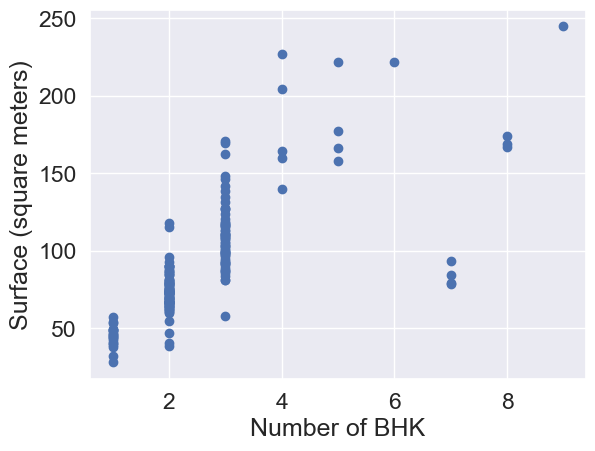

In [22]:
plt.scatter(df_norm['Property Type'], df_norm['Property Area in Sq. Ft.']*.1 )
plt.xlabel('Number of BHK')
plt.ylabel('Surface (square meters)')
plt.show()

In [23]:
df_norm.drop(index=df_norm[df_norm['Property Type'] == 7].index, inplace=True)
df_norm.shape


(194, 17)

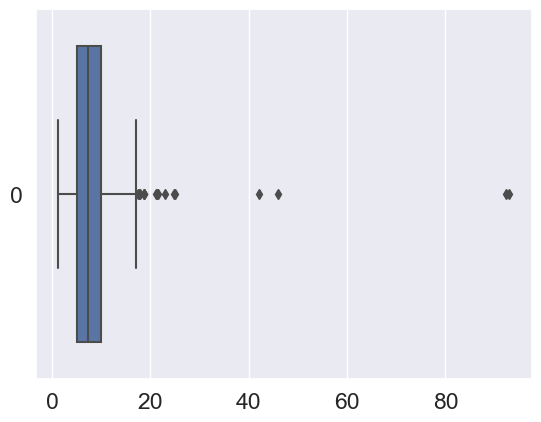

In [24]:
sns.boxplot(data=df_norm['Price in Millions'], orient='h')
plt.show()

In [25]:
x_pim = df_norm['Price in Millions']
pim_up_lim = compute_upper(x_pim)
df_norm[ x_pim > pim_up_lim ]

,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in lakhs,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
11,12,"Pune, Maharashtra, India",Ravet,5.0,2220.0,188,18.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
12,13,"Pune, Maharashtra, India",Ravet,6.0,2220.0,188,18.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
67,68,"Pune, Maharashtra, India",kayani nagar,3.0,1698.0,249,24.9,sagitarius ecospaces llp,bluegrass residences,NaN,yes,no,no,no,yes,yes,yes
68,69,"Pune, Maharashtra, India",kayani nagar,4.0,2267.0,460,46.0,sagitarius ecospaces llp,bluegrass residences,NaN,yes,no,no,no,yes,yes,yes
73,74,"Pune, Maharashtra, India",pisoli,3.0,923.0,923,92.3,nirman developers,brookefield willows,NaN,yes,no,no,no,yes,yes,yes
74,75,"Pune, Maharashtra, India",pisoli,3.0,930.0,930,93.0,nirman developers,brookefield willows,NaN,yes,no,no,no,yes,yes,yes
94,95,"Pune, Maharashtra, India",NIBM,3.0,1388.0,178,17.8,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes
95,96,"Pune, Maharashtra, India",NIBM,3.0,1463.0,187,18.7,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes
96,97,"Pune, Maharashtra, India",NIBM,8.0,1671.0,211,21.1,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes
97,98,"Pune, Maharashtra, India",NIBM,8.0,1687.0,213,21.3,kundan Spaces,Presidia,NaN,yes,no,no,no,yes,Yes,yes


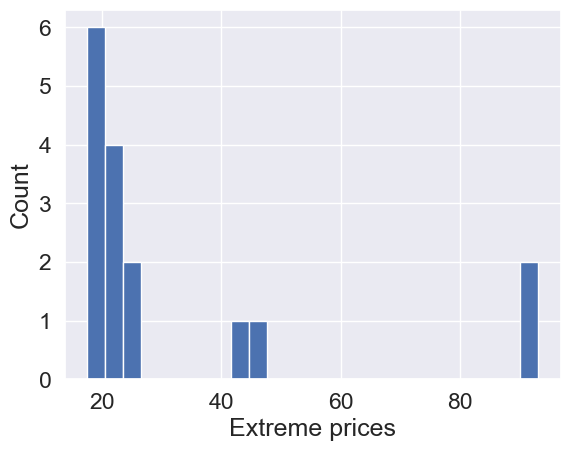

In [26]:
df_norm[x_pim > pim_up_lim]['Price in Millions'].hist(bins=25)
plt.xlabel('Extreme prices')
plt.ylabel('Count')
plt.show()

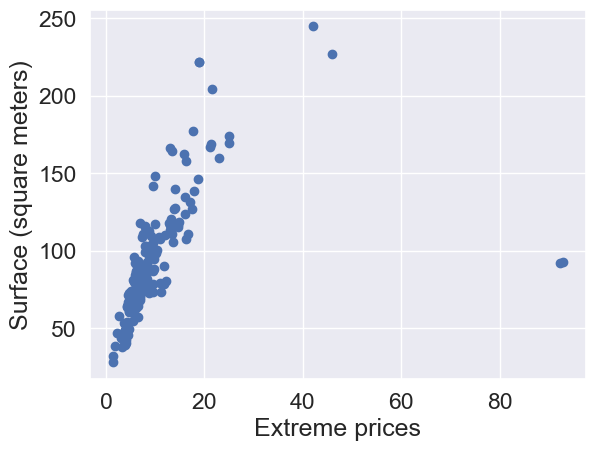

In [27]:
plt.scatter(x=df_norm['Price in Millions'],
            y=df_norm['Property Area in Sq. Ft.']*.1 )
plt.xlabel('Extreme prices')
plt.ylabel('Surface (square meters)')
plt.show()

#### From the histogram and scatter plot we can see that index 73 and 74 are definitely outliers

In [28]:
df_norm = df_norm[df_norm['Price in Millions'] < 80]

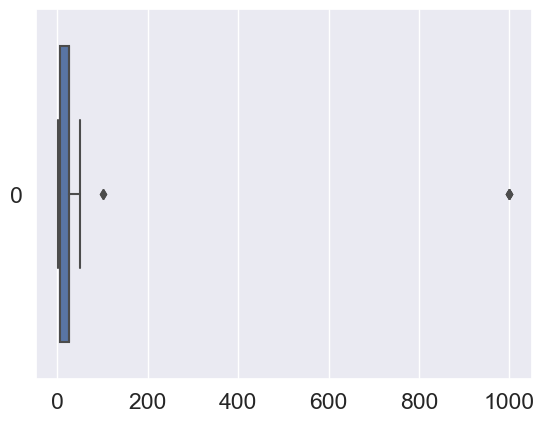

In [29]:
sns.boxplot(data=df_norm['Total TownShip Area in Acres'], orient='h')
plt.show()

In [30]:
x_tta = df_norm['Total TownShip Area in Acres']
tta_up_lim = compute_upper(x_tta)
df_norm[ x_tta > tta_up_lim ]


,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in lakhs,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
0,1,"Pune, Maharashtra, India",Bavdhan,1.0,492.0,39,3.9,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,2,"Pune, Maharashtra, India",Bavdhan,2.0,774.0,65,6.5,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2,3,"Pune, Maharashtra, India",Bavdhan,3.0,889.0,74,7.4,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3,4,"Pune, Maharashtra, India",Bavdhan,3.0,1018.0,89,8.9,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4,5,"Pune, Maharashtra, India",Mahalunge,2.0,743.0,74,7.4,Godrej Properties,Godrej Hills retreat,100.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
5,6,"Pune, Maharashtra, India",Mahalunge,3.0,975.0,95,9.5,Godrej Properties,Godrej Hills retreat,100.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes


In [31]:
tta_low_lim = compute_upper(x_tta)
df_norm[ x_tta < tta_low_lim ]

,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in lakhs,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
6,7,"Pune, Maharashtra, India",Balewadi,2.0,894.5,75,7.5,ANP CORP,ANP Universe,25.0,Yes,No,No,No,Yes,Yes,Yes
7,8,"Pune, Maharashtra, India",Balewadi,3.0,1174.5,100,10.0,ANP CORP,ANP Universe,25.0,Yes,No,No,No,Yes,Yes,Yes
8,9,"Pune, Maharashtra, India",Ravet,2.0,905.0,65,6.5,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
9,10,"Pune, Maharashtra, India",Ravet,3.0,1125.0,88,8.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
10,11,"Pune, Maharashtra, India",Ravet,4.0,1644.0,135,13.5,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
11,12,"Pune, Maharashtra, India",Ravet,5.0,2220.0,188,18.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
12,13,"Pune, Maharashtra, India",Ravet,6.0,2220.0,188,18.8,Urban Space Creator,Urban Skyline,10.0,Yes,No,No,No,Yes,Yes,Yes
13,14,"Pune, Maharashtra, India",Baner,2.0,753.5,58,5.8,VTP Reality,VTP Cierra,10.0,Yes,No,No,No,Yes,Yes,Yes
14,15,"Pune, Maharashtra, India",Baner,3.0,1051.0,95,9.5,VTP Reality,VTP Cierra,10.0,Yes,No,No,No,Yes,Yes,Yes
15,16,"Pune, Maharashtra, India",Mahalunge,1.0,423.0,40,4.0,VTP Reality,VTP Blue Water,50.0,Yes,No,No,No,Yes,Yes,Yes


### Price Selection

In [32]:
df_norm['Price in lakhs'] = df_norm['Price in lakhs'].apply(lambda x: pd.to_numeric(x, errors='coerce'))

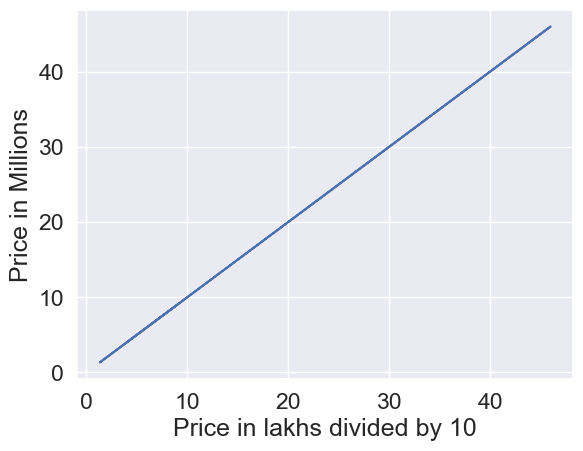

In [33]:
plt.plot(df_norm['Price in lakhs'] / 10., df_norm['Price in Millions'])
plt.xlabel('Price in lakhs divided by 10')
plt.ylabel('Price in Millions')
plt.show()

#### from this plot we conclude that price in lakhs is the same as price in millions<br>we will drop price in lakhs

In [34]:
df_norm = df_norm.drop(columns=['Price in lakhs'])

In [35]:
df_norm.head()

,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
0,1,"Pune, Maharashtra, India",Bavdhan,1.0,492.0,3.9,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,2,"Pune, Maharashtra, India",Bavdhan,2.0,774.0,6.5,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2,3,"Pune, Maharashtra, India",Bavdhan,3.0,889.0,7.4,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
3,4,"Pune, Maharashtra, India",Bavdhan,3.0,1018.0,8.9,Shapoorji Paloonji,Vanaha,1000.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes
4,5,"Pune, Maharashtra, India",Mahalunge,2.0,743.0,7.4,Godrej Properties,Godrej Hills retreat,100.0,Yes,Yes,Yes,Yes,Yes,Yes,Yes


### Handling missing values

In [36]:
df_norm.isna().sum()

Sr. No.                               0
Location                              0
Sub-Area                              0
Property Type                         0
Property Area in Sq. Ft.              0
Price in Millions                     0
Company Name                          0
TownShip Name/ Society Name           0
Total TownShip Area in Acres        140
ClubHouse                             0
School / University in Township       0
Hospital in TownShip                  0
Mall in TownShip                      0
Park / Jogging track                  0
Swimming Pool                         0
Gym                                   0
dtype: int64

In [37]:
def compute_fill_rate(df):
    fr = pd.DataFrame(1-df.isnull().sum().values.reshape(1,-1)/df.shape[0], columns=df.columns)
    return fr


def plot_fill_rate(df):
    fill_rate = compute_fill_rate(df)
    fig, ax = plt.subplots(figsize=(18, 18))
    sns.barplot(data=fill_rate, orient='h')
    ax.set_title('Fill rate for columns', fontsize=28)
    ax.set(xlim=(0, 1.))

def drop_empty_axis(df, minFillRate, axis=1):
    i = 0 if axis == 1 else 1
    return df.dropna(axis=axis, thresh=int(df.shape[i] * minFillRate))


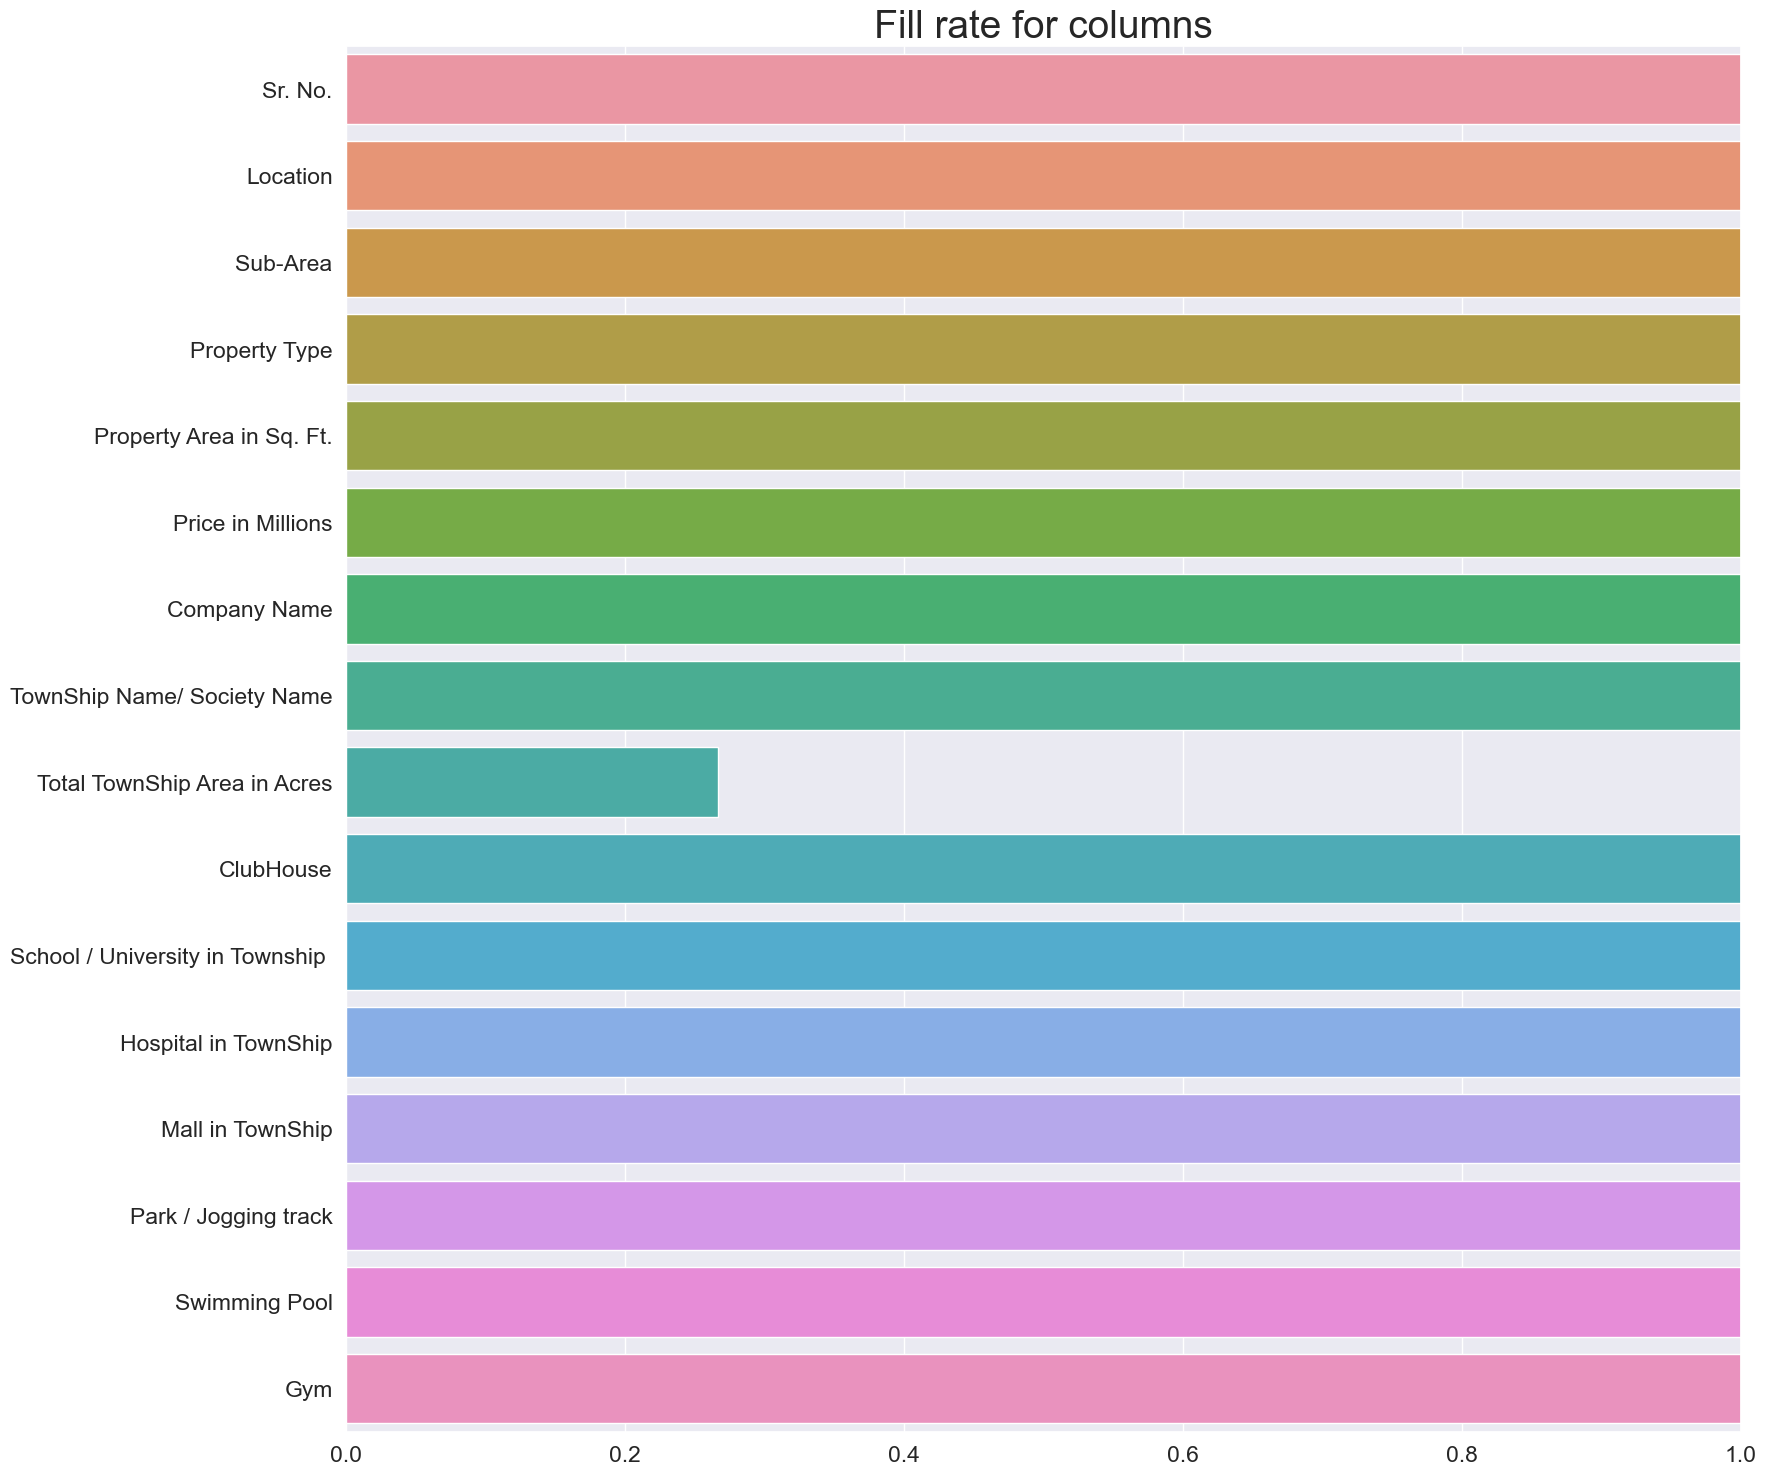

In [38]:
plot_fill_rate(df_norm)

In [39]:
compute_fill_rate(df_norm)

,Sr. No.,Location,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in Millions,Company Name,TownShip Name/ Society Name,Total TownShip Area in Acres,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.267016,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [40]:
df_norm[['Sub-Area', 'TownShip Name/ Society Name', 'Total TownShip Area in Acres' ]].sort_values('Sub-Area').reset_index(drop=True)

,Sub-Area,TownShip Name/ Society Name,Total TownShip Area in Acres
0,Akurdi,Mantra Sky Tower,3.5
1,Akurdi,Mantra Sky Tower,3.5
2,Akurdi,Mantra Sky Tower,3.5
3,Akurdi,Mantra Sky Tower,3.5
4,Akurdi,Mantra Sky Tower,3.5
5,Akurdi,Mantra Sky Tower,3.5
6,BANER,TEJ ELEVIA,2.5
7,BANER,vtp solitaire,NaN
8,BANER,SUPREME ESTIA,5.0
9,BANER,SUPREME ESTIA,5.0


In [41]:
df_norm = drop_empty_axis(df_norm, minFillRate=.5)

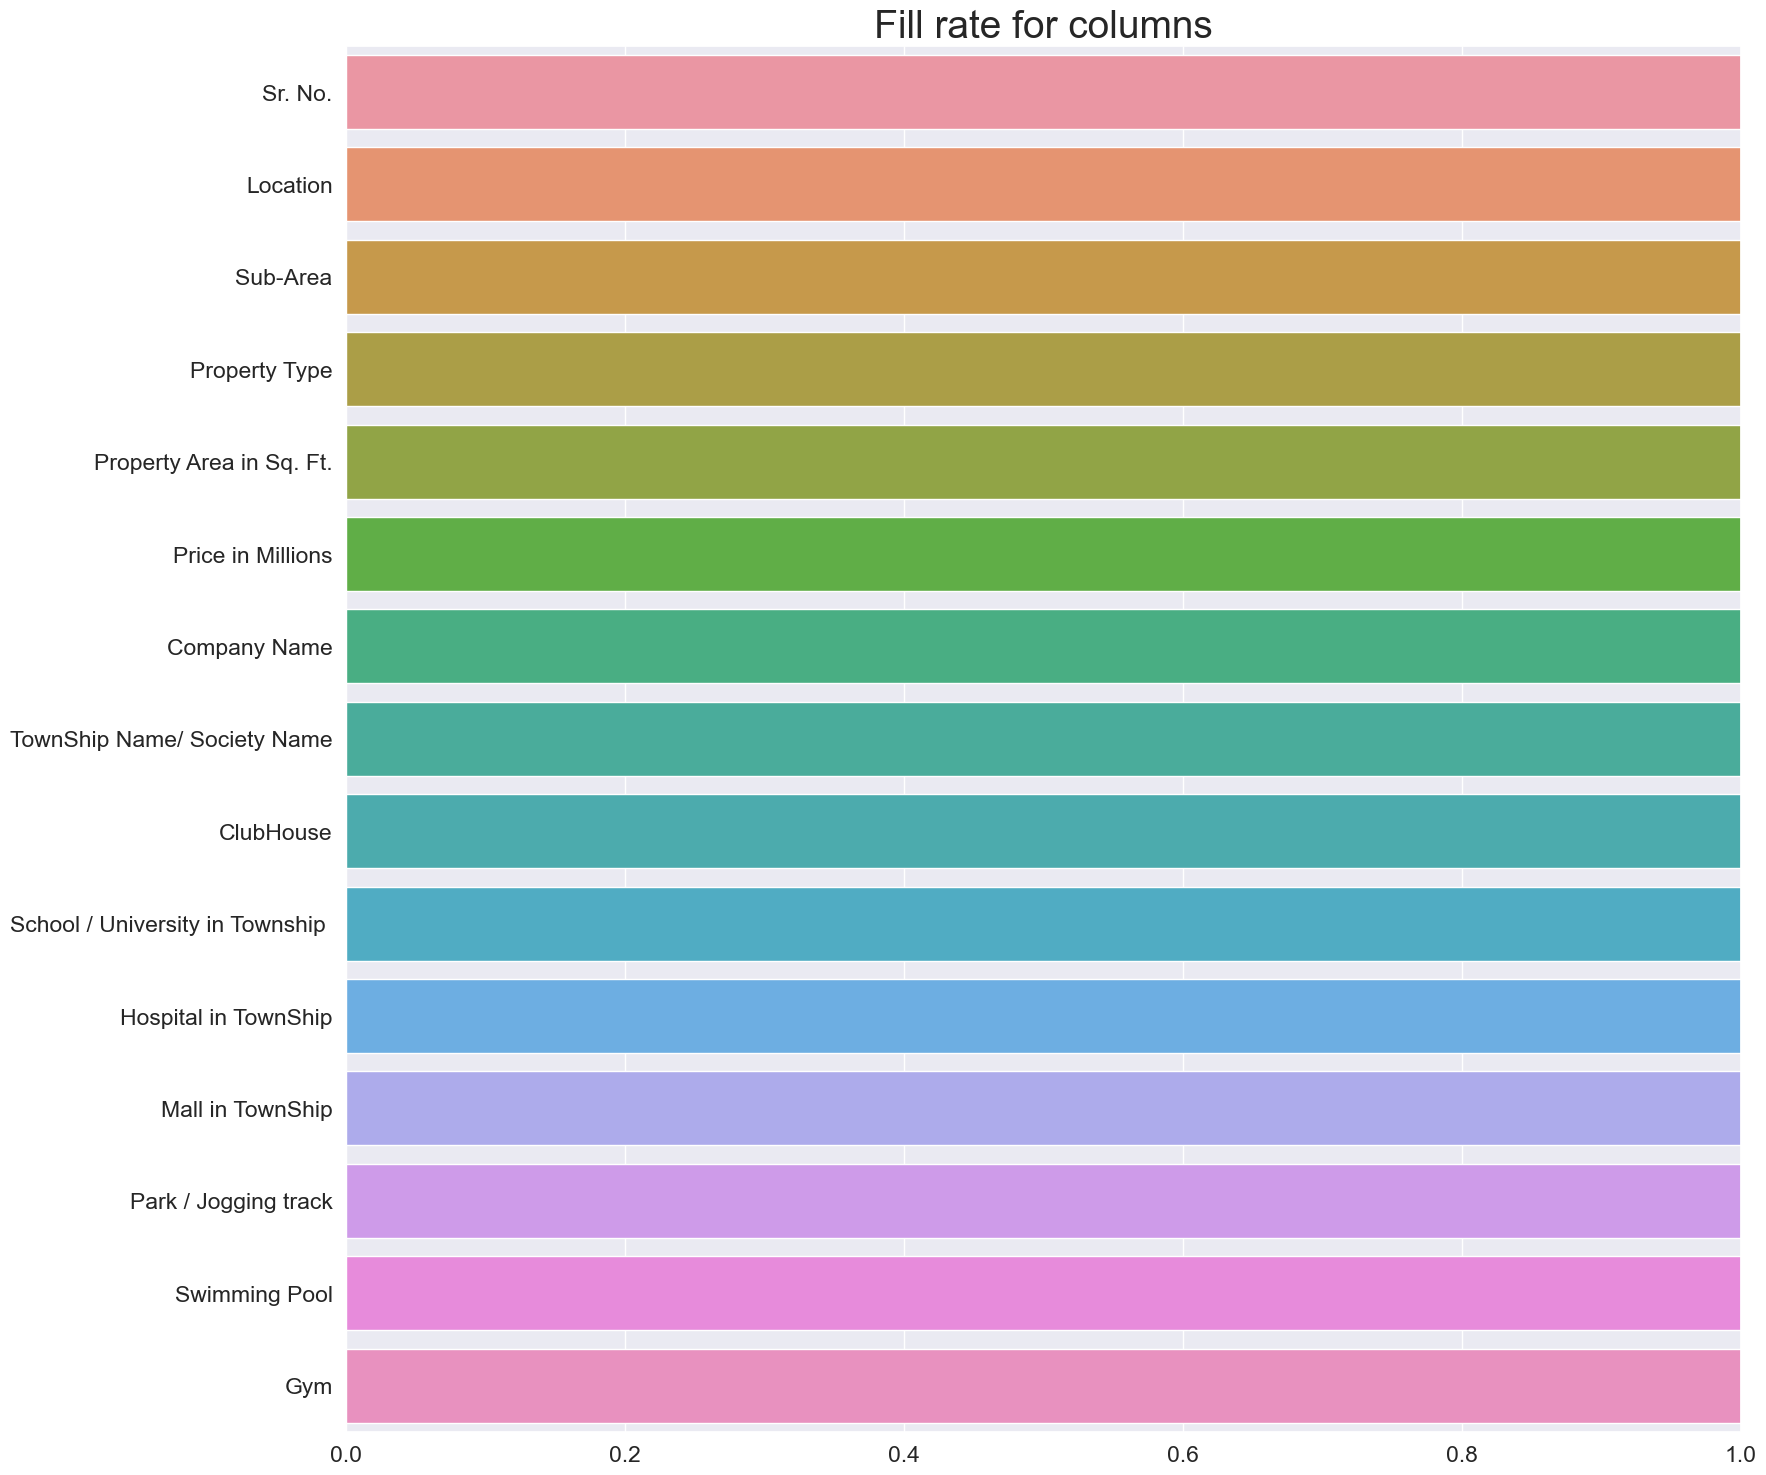

In [42]:
plot_fill_rate(df_norm)

#### Regularize the categorical columns

In [43]:
df_norm.select_dtypes(include='object').head(3)

,Location,Sub-Area,Company Name,TownShip Name/ Society Name,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
0,"Pune, Maharashtra, India",Bavdhan,Shapoorji Paloonji,Vanaha,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1,"Pune, Maharashtra, India",Bavdhan,Shapoorji Paloonji,Vanaha,Yes,Yes,Yes,Yes,Yes,Yes,Yes
2,"Pune, Maharashtra, India",Bavdhan,Shapoorji Paloonji,Vanaha,Yes,Yes,Yes,Yes,Yes,Yes,Yes


### Binary categorical columns

In [44]:
binary_cols = df_norm.iloc[:,-7:].columns.to_list()
binary_cols

['ClubHouse',
 'School / University in Township ',
 'Hospital in TownShip',
 'Mall in TownShip',
 'Park / Jogging track',
 'Swimming Pool',
 'Gym']

In [45]:
def print_uniques(cols, df=df_norm):
    for col in cols:
        list_unique = df[col].unique()
        list_unique.sort()
        print(col, ":\n", list_unique)
        print('Number of unique categories:', len(list_unique))
        print('------------------')

In [46]:
print_uniques(binary_cols)

ClubHouse :
 ['Yes' 'no' 'no ' 'yes']
Number of unique categories: 4
------------------
School / University in Township  :
 ['No' 'Yes' 'no']
Number of unique categories: 3
------------------
Hospital in TownShip :
 ['No' 'Yes' 'no']
Number of unique categories: 3
------------------
Mall in TownShip :
 ['No' 'Yes' 'no' 'no ']
Number of unique categories: 4
------------------
Park / Jogging track :
 ['No' 'Yes' 'no' 'yes']
Number of unique categories: 4
------------------
Swimming Pool :
 ['No' 'Yes' 'no' 'no ' 'yes']
Number of unique categories: 5
------------------
Gym :
 ['Yes' 'no' 'no ' 'yes']
Number of unique categories: 4
------------------


In [47]:
for col in binary_cols:
    df_norm[col] = df_norm[col].apply(lambda x: x.strip().lower())

print_uniques(binary_cols)

ClubHouse :
 ['no' 'yes']
Number of unique categories: 2
------------------
School / University in Township  :
 ['no' 'yes']
Number of unique categories: 2
------------------
Hospital in TownShip :
 ['no' 'yes']
Number of unique categories: 2
------------------
Mall in TownShip :
 ['no' 'yes']
Number of unique categories: 2
------------------
Park / Jogging track :
 ['no' 'yes']
Number of unique categories: 2
------------------
Swimming Pool :
 ['no' 'yes']
Number of unique categories: 2
------------------
Gym :
 ['no' 'yes']
Number of unique categories: 2
------------------


#### Multi-categorical columns

In [48]:
obj_cols = df_norm.select_dtypes(include='object').columns.to_list()
multiCat_cols = list(set(obj_cols)^set(binary_cols))
multiCat_cols

['Sub-Area', 'Company Name', 'Location', 'TownShip Name/ Society Name']

In [49]:
for col in multiCat_cols:
    df_norm[col] = df_norm[col].apply(lambda x: x.strip().lower())

In [50]:
print_uniques(multiCat_cols)

Sub-Area :
 ['akurdi' 'balewadi' 'baner' 'bavdhan' 'bavdhan budruk' 'bt kawade rd'
 'dhanori' 'hadapsar' 'handewadi' 'hinjewadi' 'karvanagar' 'kayani nagar'
 'keshav nagar' 'kharadi' 'kirkatwadi sinhagad road' 'kiwale'
 'koregaon park' 'koregoan' 'lonavala' 'magarpatta' 'mahalunge' 'manjri'
 'mohammadwadi' 'mundhwa' 'nibm' 'pisoli' 'ravet' 'susgaon' 'talegoan'
 'tathawade' 'undri' 'vimannagar' 'wadgaon sheri']
Number of unique categories: 33
------------------
Company Name :
 ['ace constructions' 'anp corp' 'bhaktamar realities' 'calyx spaces'
 'dolphin group' 'godrej properties' 'jhala group' 'kalpataru'
 'keystone landmark' 'kohinoor group' 'kundan spaces' 'lush life'
 'maha anand pinnac associates' 'majestique landmarks' 'mantra properties'
 'nirman developers' 'oxy buildcorp' 'porwal  develkoper'
 'porwal & anand develkoper' 'proviso group' 'puraniks' 'ravima ventures'
 'sagitarius ecospaces llp' 'shapoorji paloonji' 'shroff developers'
 'sukwani associates' 'supreme' 'tejraaj grou

#### According to this we have 53 tonwships, which are constructed by 37 companies<br>we also have 1 Location which we will drop for it doesn't contain any new information

In [51]:
df_norm.drop(columns=['Location'], inplace=True)

In [52]:
display(df_norm.head(), df_norm.shape)

,Sr. No.,Sub-Area,Property Type,Property Area in Sq. Ft.,Price in Millions,Company Name,TownShip Name/ Society Name,ClubHouse,School / University in Township,Hospital in TownShip,Mall in TownShip,Park / Jogging track,Swimming Pool,Gym
0,1,bavdhan,1.0,492.0,3.9,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
1,2,bavdhan,2.0,774.0,6.5,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
2,3,bavdhan,3.0,889.0,7.4,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
3,4,bavdhan,3.0,1018.0,8.9,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
4,5,mahalunge,2.0,743.0,7.4,godrej properties,godrej hills retreat,yes,yes,yes,yes,yes,yes,yes


(191, 14)

### Saving the cleaned data set and renaming the column names

In [53]:
df_norm.columns=['index', 'sub_area', 'n_bhk', 'surface', 'price', 
                 'company_name', 'township', 'club_house', 'school', 
                 'hospital', 'mall', 'park', 'pool', 'gym']

In [54]:
df_norm.head()

,index,sub_area,n_bhk,surface,price,company_name,township,club_house,school,hospital,mall,park,pool,gym
0,1,bavdhan,1.0,492.0,3.9,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
1,2,bavdhan,2.0,774.0,6.5,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
2,3,bavdhan,3.0,889.0,7.4,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
3,4,bavdhan,3.0,1018.0,8.9,shapoorji paloonji,vanaha,yes,yes,yes,yes,yes,yes,yes
4,5,mahalunge,2.0,743.0,7.4,godrej properties,godrej hills retreat,yes,yes,yes,yes,yes,yes,yes


In [55]:
df_norm.to_csv('Data/resd_clean.csv', index=False)

In [56]:
df = pd.read_csv('Data/resd_clean.csv')

In [57]:
df.shape, df.columns

((191, 14),
 Index(['index', 'sub_area', 'n_bhk', 'surface', 'price', 'company_name',
        'township', 'club_house', 'school', 'hospital', 'mall', 'park', 'pool',
        'gym'],
       dtype='object'))

#### we will drop the index, company name and township columns as they are not relevant for our analysis

In [58]:
df['company_name'].unique(), df['township'].unique()

(array(['shapoorji paloonji', 'godrej properties', 'anp corp',
        'urban space creator', 'vtp reality', 'waghvani constructions',
        'sukwani associates', 'mantra properties', 'ravima ventures',
        'proviso group', 'unique properties', 'sagitarius ecospaces llp',
        'nirman developers', 'jhala group', 'shroff developers',
        'kundan spaces', 'venkatesh bhoomi construction', 'lush life',
        'maha anand pinnac associates', 'vasupujya corporation',
        'ace constructions', 'wellwisher apartments', 'dolphin group',
        'oxy buildcorp', 'kohinoor group', 'bhaktamar realities',
        'porwal & anand develkoper', 'porwal  develkoper',
        'keystone landmark', 'puraniks', 'majestique landmarks',
        'kalpataru', 'vijaya laxmi creations',
        'vijaya laxmi infrarealtors', 'calyx spaces', 'supreme',
        'tejraaj group'], dtype=object),
 array(['vanaha', 'godrej hills retreat', 'anp universe', 'urban skyline',
        'vtp cierra', 'vtp blue

In [59]:
df = df.drop(columns=['index', 'company_name', 'township']).drop_duplicates() 

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191 entries, 0 to 190
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sub_area    191 non-null    object 
 1   n_bhk       191 non-null    float64
 2   surface     191 non-null    float64
 3   price       191 non-null    float64
 4   club_house  191 non-null    object 
 5   school      191 non-null    object 
 6   hospital    191 non-null    object 
 7   mall        191 non-null    object 
 8   park        191 non-null    object 
 9   pool        191 non-null    object 
 10  gym         191 non-null    object 
dtypes: float64(3), object(8)
memory usage: 17.9+ KB


In [61]:
df.tail(10)

,sub_area,n_bhk,surface,price,club_house,school,hospital,mall,park,pool,gym
181,bavdhan,2.0,665.0,6.499,yes,no,no,no,yes,no,no
182,talegoan,1.0,280.0,1.319,yes,no,no,no,yes,yes,yes
183,talegoan,2.0,385.0,1.729,yes,no,no,no,yes,no,yes
184,baner,2.0,730.0,8.700,yes,no,no,no,yes,yes,yes
185,baner,3.0,1135.0,12.900,yes,no,no,no,yes,yes,yes
186,baner,3.0,1350.0,16.000,yes,no,no,no,yes,yes,yes
187,baner,4.0,1600.0,23.000,yes,no,no,no,yes,yes,yes
188,baner,2.0,789.0,9.500,no,no,no,no,yes,yes,yes
189,baner,3.0,1107.0,13.500,no,no,no,no,yes,yes,yes
190,baner,2.0,776.0,9.068,yes,no,no,no,yes,yes,yes


### Converting binary columns to dummy variables

In [62]:
binary_cols = df.iloc[:,4:].columns.to_list()
binary_cols

['club_house', 'school', 'hospital', 'mall', 'park', 'pool', 'gym']

In [63]:
# average price for appartments with pool and without pool
df[['price', 'pool']].groupby('pool')['price'].mean()

pool
no      6.470113
yes    10.039575
Name: price, dtype: float64

In [64]:
df[['price', 'pool']].groupby('pool')['price'].mean()

pool
no      6.470113
yes    10.039575
Name: price, dtype: float64

#### from this we can say that appartments with pools are on average 3.5 millions more expensive

In [65]:
le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

df.tail(10)

,sub_area,n_bhk,surface,price,club_house,school,hospital,mall,park,pool,gym
181,bavdhan,2.0,665.0,6.499,1,0,0,0,1,0,0
182,talegoan,1.0,280.0,1.319,1,0,0,0,1,1,1
183,talegoan,2.0,385.0,1.729,1,0,0,0,1,0,1
184,baner,2.0,730.0,8.700,1,0,0,0,1,1,1
185,baner,3.0,1135.0,12.900,1,0,0,0,1,1,1
186,baner,3.0,1350.0,16.000,1,0,0,0,1,1,1
187,baner,4.0,1600.0,23.000,1,0,0,0,1,1,1
188,baner,2.0,789.0,9.500,0,0,0,0,1,1,1
189,baner,3.0,1107.0,13.500,0,0,0,0,1,1,1
190,baner,2.0,776.0,9.068,1,0,0,0,1,1,1


### Sub areas contribution

In [66]:
df_sa_count = df.groupby('sub_area')['price'].count().reset_index()\
              .rename(columns={'price': 'count'})\
              .sort_values('count', ascending=False)\
              .reset_index(drop=True)
df_sa_count['sa_contribution'] = df_sa_count['count'] / len(df)
df_sa_count

,sub_area,count,sa_contribution
0,kharadi,16,0.083770
1,baner,12,0.062827
2,ravet,12,0.062827
3,bavdhan,10,0.052356
4,bt kawade rd,10,0.052356
5,handewadi,10,0.052356
6,wadgaon sheri,9,0.047120
7,hinjewadi,9,0.047120
8,mahalunge,9,0.047120
9,hadapsar,8,0.041885


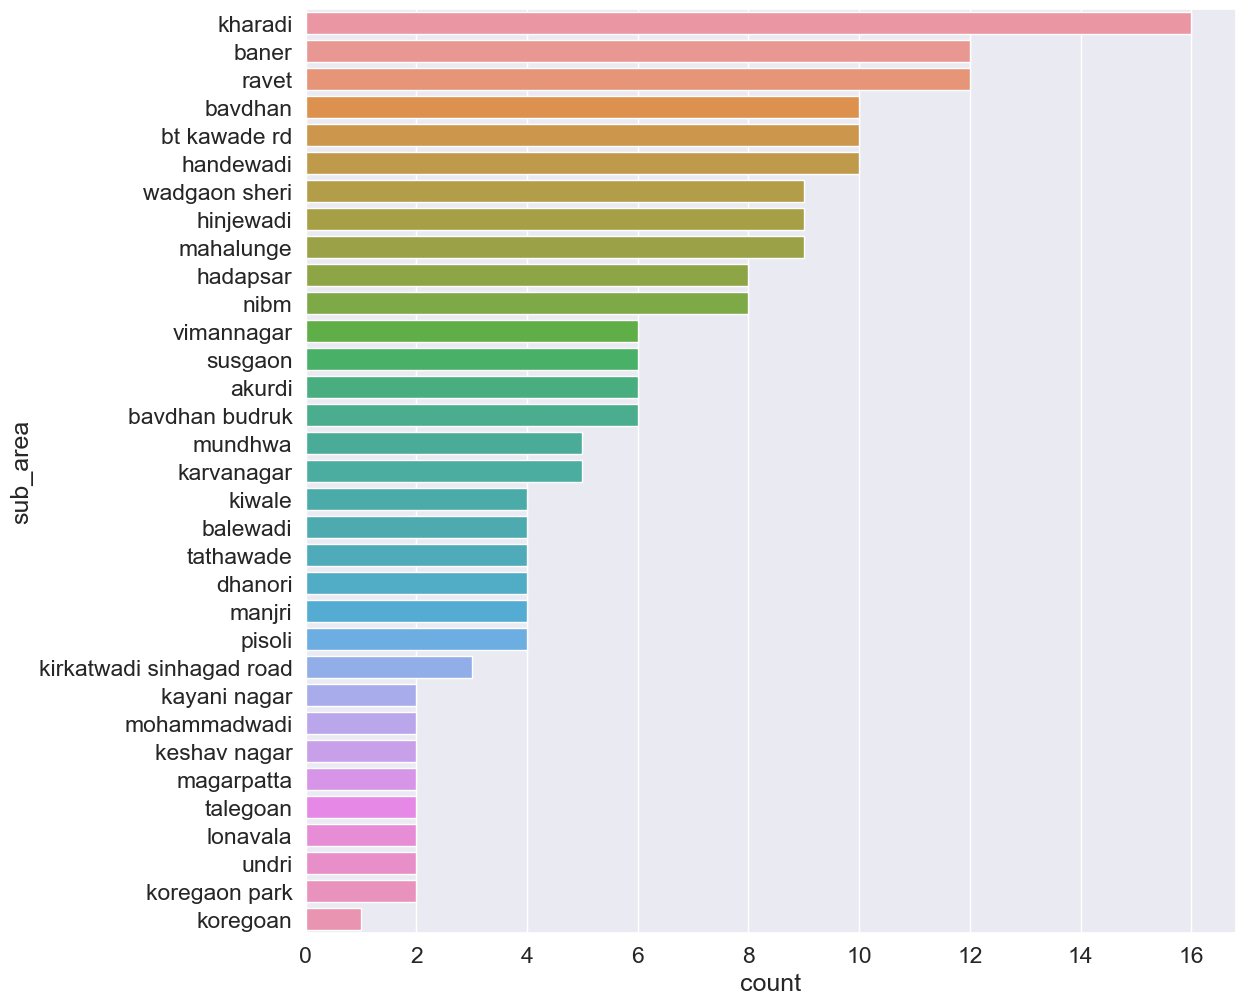

In [67]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.barplot(data=df_sa_count, x='count', y='sub_area')
plt.show()

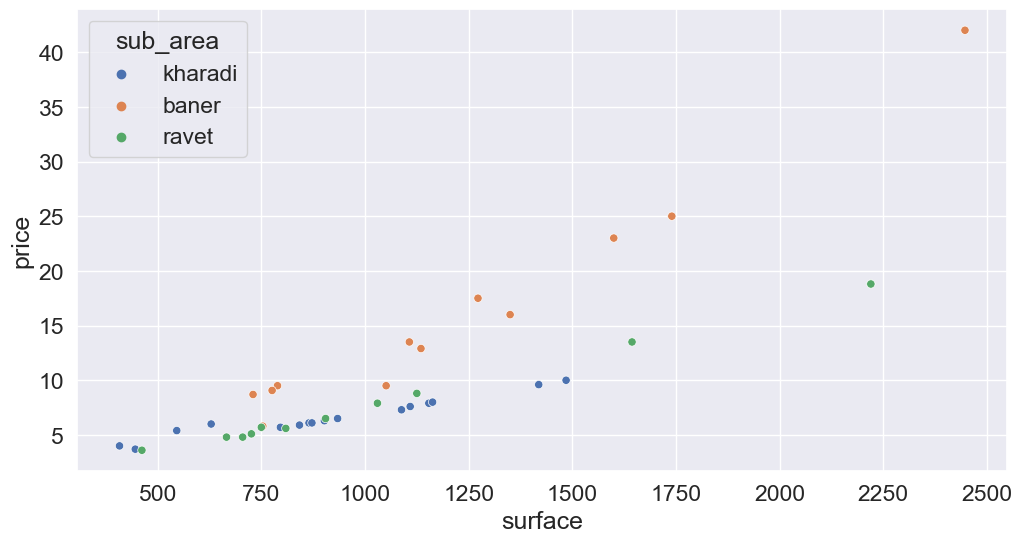

In [68]:
fig, ax = plt.subplots(figsize=(12, 6))
df_plot = df_sa_count.merge(df[['sub_area', 'surface', 'price']], on='sub_area')
df_plot = df_plot[df_plot['count'] > 11]

sns.scatterplot(data=df_plot, x='surface', y='price', hue='sub_area')
plt.show()

### Feature engineering

In [69]:
len(df_sa_count), np.mean(df_sa_count['count'])

(33, 5.787878787878788)

In [70]:
sa_sel_col = df_sa_count.loc[df_sa_count['count'] > 7, 'sub_area'].to_list()
df['sub_area'] = df['sub_area'].where(df['sub_area'].isin(sa_sel_col), 'other')

In [71]:
df['sub_area'].unique(), len(df['sub_area'].unique())

(array(['bavdhan', 'mahalunge', 'other', 'ravet', 'baner', 'kharadi',
        'hadapsar', 'handewadi', 'nibm', 'bt kawade rd', 'hinjewadi',
        'wadgaon sheri'], dtype=object),
 12)

### Converting Sub-area to dummy variables

In [72]:
ohe = OneHotEncoder(sparse_output=False)
X_dummy = ohe.fit_transform(df[['sub_area']])
X_dummy.shape, X_dummy, X_dummy.dtype

((191, 12),
 array([[0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]]),
 dtype('float64'))

In [73]:
X_dummy = X_dummy.astype('int64')

In [74]:
sa_cols_name = ['sa'+str(i+1) for i in range(X_dummy.shape[1])]
df.loc[:, sa_cols_name] = X_dummy
df.head()

/var/folders/0h/5yv3vz210dx61dfqmldvk_h40000gn/T/ipykernel_31582/960799325.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, sa_cols_name] = X_dummy


,sub_area,n_bhk,surface,price,club_house,school,hospital,mall,park,pool,gym,sa1,sa2,sa3,sa4,sa5,sa6,sa7,sa8,sa9,sa10,sa11,sa12
0,bavdhan,1.0,492.0,3.9,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
1,bavdhan,2.0,774.0,6.5,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
2,bavdhan,3.0,889.0,7.4,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
3,bavdhan,3.0,1018.0,8.9,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
4,mahalunge,2.0,743.0,7.4,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0


In [75]:
df[['sub_area']+sa_cols_name].drop_duplicates()\
.sort_values('sub_area').reset_index(drop=True)

,sub_area,sa1,sa2,sa3,sa4,sa5,sa6,sa7,sa8,sa9,sa10,sa11,sa12
0,baner,1,0,0,0,0,0,0,0,0,0,0,0
1,bavdhan,0,1,0,0,0,0,0,0,0,0,0,0
2,bt kawade rd,0,0,1,0,0,0,0,0,0,0,0,0
3,hadapsar,0,0,0,1,0,0,0,0,0,0,0,0
4,handewadi,0,0,0,0,1,0,0,0,0,0,0,0
5,hinjewadi,0,0,0,0,0,1,0,0,0,0,0,0
6,kharadi,0,0,0,0,0,0,1,0,0,0,0,0
7,mahalunge,0,0,0,0,0,0,0,1,0,0,0,0
8,nibm,0,0,0,0,0,0,0,0,1,0,0,0
9,other,0,0,0,0,0,0,0,0,0,1,0,0


### Univariate and bivariate analysis

In [76]:
data = df.select_dtypes(exclude='object')
data.head()

,n_bhk,surface,price,club_house,school,hospital,mall,park,pool,gym,sa1,sa2,sa3,sa4,sa5,sa6,sa7,sa8,sa9,sa10,sa11,sa12
0,1.0,492.0,3.9,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
1,2.0,774.0,6.5,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
2,3.0,889.0,7.4,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
3,3.0,1018.0,8.9,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0
4,2.0,743.0,7.4,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0


In [77]:
data.describe()

,n_bhk,surface,price,club_house,school,hospital,mall,park,pool,gym,sa1,sa2,sa3,sa4,sa5,sa6,sa7,sa8,sa9,sa10,sa11,sa12
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.00000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,2.471204,898.523560,8.712707,0.738220,0.031414,0.031414,0.031414,0.979058,0.628272,0.811518,0.062827,0.052356,0.052356,0.041885,0.052356,0.047120,0.08377,0.047120,0.041885,0.408377,0.062827,0.047120
std,1.186751,376.550204,5.860711,0.440759,0.174891,0.174891,0.174891,0.143568,0.484536,0.392124,0.243290,0.223329,0.223329,0.200852,0.223329,0.212453,0.27777,0.212453,0.200852,0.492825,0.243290,0.212453
min,1.000000,280.000000,1.319000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,670.000000,5.078000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,796.000000,7.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,1055.500000,9.793500,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000
max,9.000000,2447.000000,46.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000


### Continuous variables

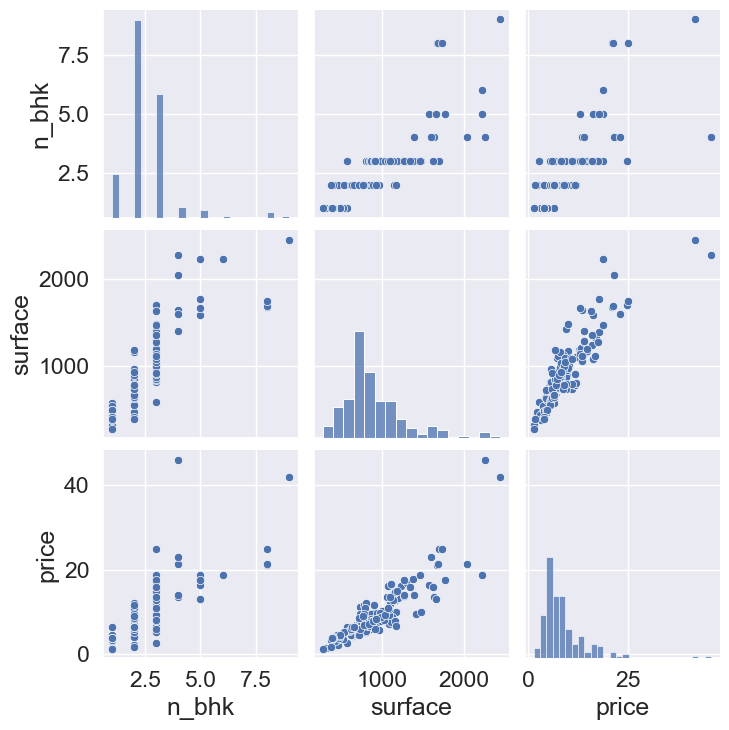

In [78]:
float_cols = data.select_dtypes(include='float64').columns.to_list()
sns.pairplot(data[float_cols])
plt.show()

### Binary variables

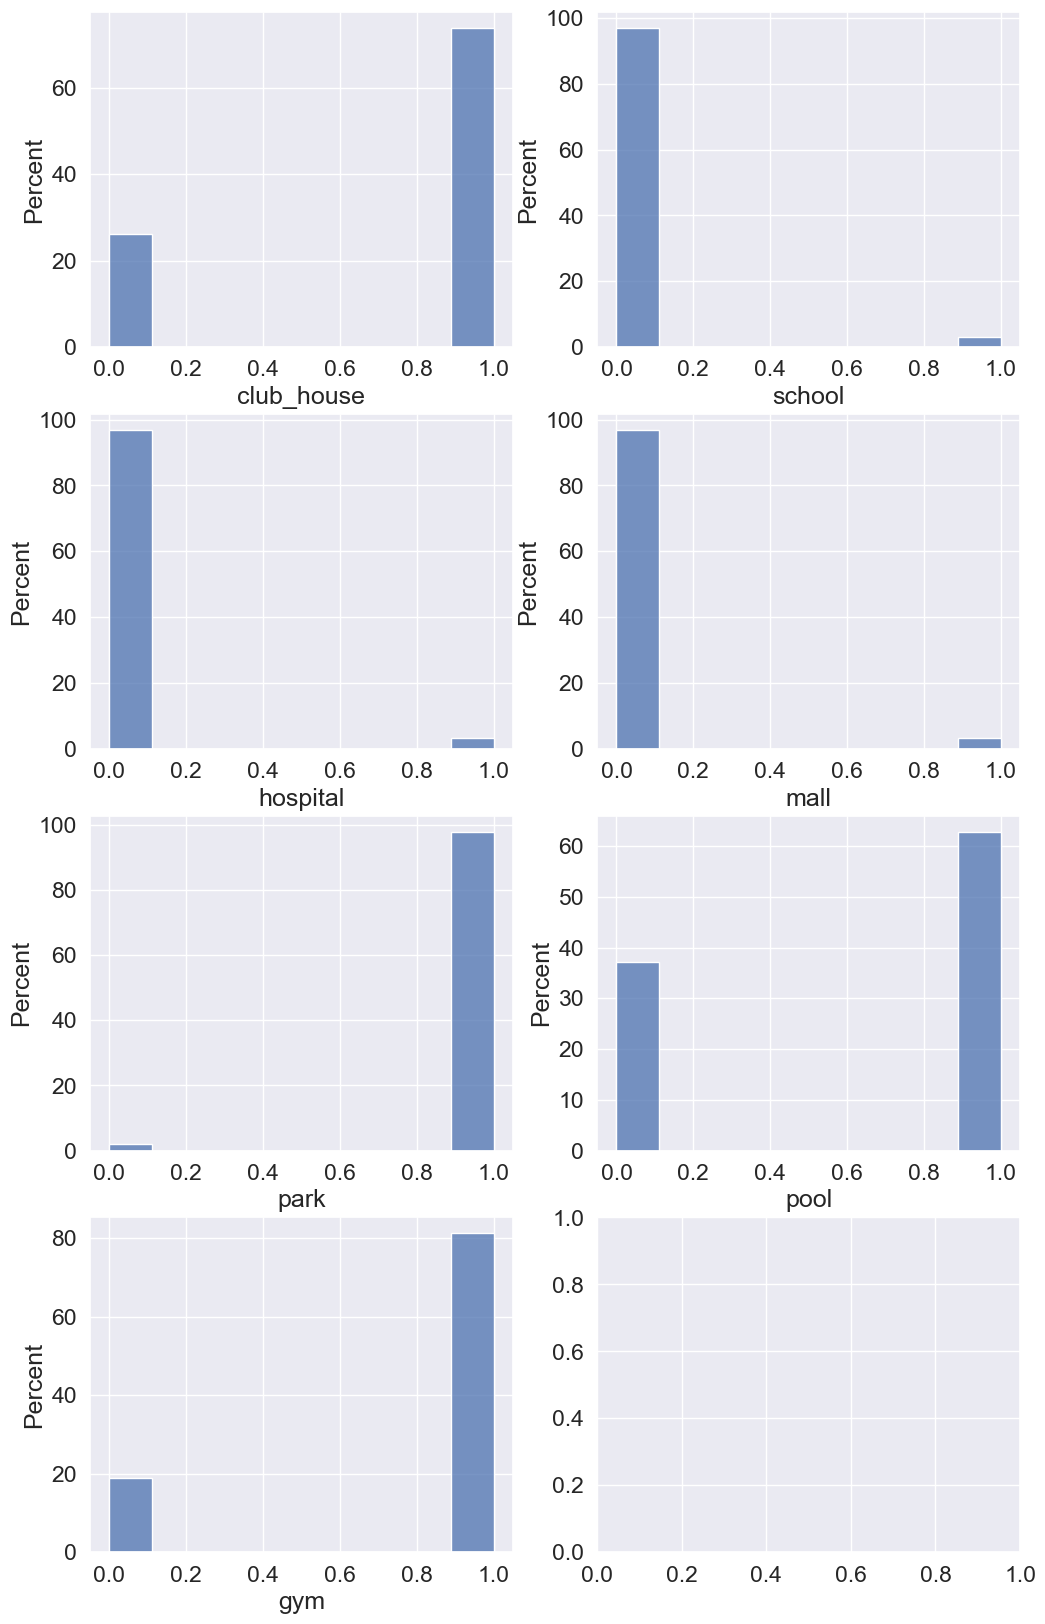

In [79]:
fig, ax = plt.subplots(4, 2, figsize=(12, 20))
for i, col in enumerate(binary_cols):
    sns.histplot(data, x=col, ax=ax[int(i/2), i%2], stat='percent')

### Correlation map

In [80]:
corr_cols_list = float_cols + binary_cols
correl = data[corr_cols_list].corr()
mask = np.zeros_like(correl, dtype=bool)
mask[np.triu_indices_from(mask)] = True

fig, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(correl, mask=mask, vmin=-1, cmap='Greys', annot=True, fmt='.1g')
plt.show()

## Feature Selection

In [ ]:
# price corr with all other columns
corr_cols_list.remove('price')
corr_cols_list.extend(sa_cols_name)
corr_list = [] # to keep corr with price
for col in corr_cols_list:
    corr_list.append(round(data['price'].corr(data[col]), 2))

corr_list

In [ ]:
# sorted corr
df_corr = pd.DataFrame(data=zip(corr_cols_list, corr_list),
                       columns=['col_name', 'corr'])\
                       .sort_values('corr', ascending=False)\
                        .reset_index(drop=True)
df_corr

In [ ]:
# Distribution of corr with price
fig, ax = plt.subplots(figsize=(15, 5))
abs(df_corr['corr']).hist(bins=50)
ax.set_xticks(np.arange(0, 1, 0.05))
plt.xticks(rotation=45)
plt.show()

In [ ]:
features = df_corr.loc[abs(df_corr['corr']) > .1, 'col_name'].to_list()
features, len(features)

In [ ]:
# Keeping the sub areas' name, their mean price and frequency (count)
sa_features_list = [sa for sa in features if 'sa' in sa]
sa_list = []
for col in sa_features_list:
  sa_triger = df[col] == 1
  sa = df.loc[sa_triger, 'sub_area'].to_list()[0]
  x = df.loc[sa_triger, 'price']
  sa_list.append((sa, np.mean(x), df[col].sum()))

sa_list

In [ ]:
# sub area mean price comparision
sa_f = pd.DataFrame(data=sa_list, columns=['sub_area', 'mean_price', 'count'])
sa_f['total_mean_price'] = np.mean(df['price'])
sa_f

### Data scaling

In [ ]:
# Selection of the final dataset
sel_data = data[features+['price']].copy()
sel_data.head()

In [ ]:
# Standard scaling for surface
sc = StandardScaler(with_std=True, with_mean=True)
sel_data['surface'] = sc.fit_transform(sel_data[['surface']])
sel_data.head()

### Saving the data

In [ ]:
sel_data.to_csv('Data/resd_features.csv', index=False)

In [ ]:
data = pd.read_csv('Data/resd_features.csv')


In [ ]:
display(data.head(), data.shape)

### Data preparation

In [ ]:
data = data.sort_values('surface').reset_index(drop=True)
data.head()

In [ ]:
# Selecting the feature matrix and target vector
X = data.iloc[:, :-1]
y = data['price']

In [ ]:
rs = 118
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

In [ ]:



def grid_search_report(estimator, X, y, pg, cv=LeaveOneOut(), rs=118):
    t0 = time()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)

    est_cv = GridSearchCV(estimator=estimator, param_grid=pg, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
    est_cv.fit(X_train, y_train)

    print('Best parameters:', est_cv.best_params_)
    print('Best CV score:', abs(est_cv.best_score_))
    y_train_pred, y_test_pred = est_cv.predict(X_train), est_cv.predict(X_test) 
    print('MSE, R2 train:', mean_squared_error(y_train, y_train_pred), r2_score(y_train, y_train_pred))
    print('MSE, R2 test:', mean_squared_error(y_test, y_test_pred), r2_score(y_test, y_test_pred))

    t = round(time() - t0, 2)
    print('Elapsed time:', t, 's ,', round(t/60, 2), 'min' )

    return est_cv
    

In [ ]:
def plot_residue(estimator, X, y, rs=118):
    """ 
    Plots the fit residuals (price - predicted_price) vs. 'surface' variable.
    Params:
      estimator: GridSearchCV, the regressor
      X: Pandas dataframe, feature data
      y: Pandas series, target
      rs: int, random state
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=rs)
    residue_train = y_train - estimator.predict(X_train)
    residue_test = y_test - estimator.predict(X_test)


    fig, axe = plt.subplots(1, 2, figsize=(18, 10))
    axe[0].scatter( X_train['surface'], residue_train, label='train')
    axe[0].scatter( X_test['surface'], residue_test, label='test')
    axe[0].plot( [-2.3, 4.5], [0, 0], 'black')
    axe[0].set_xlabel('Scaled surface')
    axe[0].set_ylabel('Fit residuals')
    axe[0].legend()

    axe[1].hist(residue_test, bins=25)
    axe[1].set_xlabel('Fit residual for test set')
    axe[1].set_ylabel('Count')
    plt.show()

    print('mean residuals:', round(np.mean(residue_test), 2),
          "\nstd:", round(np.std(residue_test), 2))



### Ordinary Linear Regession

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
r2_score(y_train, lr.predict(X_train)), r2_score(y_test, lr.predict(X_test))

In [ ]:
plot_residue(lr, X, y, rs=rs)

### Ridge Regession

In [ ]:
alphas = np.logspace(-3, 3, 100) # strength of the penalty. 100 different alpha values
pg = {'alpha': alphas}
ridge = Ridge()
ridg_cv = grid_search_report(ridge, X, y, pg, rs=rs)

In [ ]:
plot_residue(ridg_cv, X, y, rs=rs)

### Lasso Regression

In [ ]:
lasso = Lasso()
pg = {'alpha': alphas}
lasso_cv = grid_search_report(lasso, X, y, pg, rs=rs)

In [ ]:
plot_residue(lasso_cv, X, y, rs=rs)

### Lasso and Ridge Combination

In [ ]:
l1_ratio = np.random.rand(20)
elastic = ElasticNet()
pg = {'alpha': np.linspace(0.1, 1, 5), 'l1_ratio': l1_ratio}
elsativ_cv = grid_search_report(elastic, X, y, pg, rs=rs)

In [ ]:
plot_residue(elsativ_cv, X, y, rs=rs)

### Random Forest Regressor

In [ ]:
rfr = RandomForestRegressor(random_state=10)
pg = {'n_estimators': [10, 20, 30, 50],
      'criterion': ['squared_error', 'absolute_error', 'poisson'],
      'max_depth': [2, 3, 4],
      'min_samples_split': range(2, 10),
      'min_samples_leaf': [2, 3],
      'max_features': range(4, X_train.shape[1]+1)
      }

rfr_cv = grid_search_report(rfr, X, y, pg, cv=5, rs=rs)

In [ ]:
rfr = rfr_cv.best_estimator_
df_imp = pd.DataFrame(zip(rfr.feature_names_in_, rfr.feature_importances_))
df_imp.columns = ['feature', 'importance']
df_imp = df_imp.sort_values('importance', ascending=False).reset_index(drop=True)

sns.barplot(data=df_imp, x='importance', y='feature')
plt.show()

In [ ]:
plot_residue(rfr, X, y, rs=rs)

### XGboost (extreme gradient boosting)

In [ ]:
param_grid = {
    'max_depth': range(2, 7), # maximum depth of a tree, larger max_depth causes overfitting
    'gamma': uniform(loc=0.0, scale=3), # minimum of the loss function reduction to split a node
    'min_child_weight': range(3,6), # similar to min_samples_leaf, by increasing min_child_weight, the model becomes more biased, but less overfitting
    'colsample_bytree': uniform(loc=0.1, scale=0.9), # similar to max_features
    'subsample': uniform(loc=0.5, scale=0.5), # similar to bootstrapping in RF, controls the fraction of observations to be randomly sampled for each tree
    'learning_rate': uniform(loc=0.01, scale=0.99) # contribution rate of each estimator
              }

### Grid search contains 2 parts:
##### 1 prepare different sets of hyperparams (extract different random selection from param_grid ) this is done<br> by generating a list of 500 and put them in param_list (done useing ParameterSampler)

#### 2 Cross-validation: divide trainig set into n number of data folds (usually 5 or 10)<br> select n - 1 folds to train the model, and then compute the score on the last non-trained fold (validation set). Score is called validation score

In [ ]:
rng = np.random.RandomState(20)
n_iter = 500
param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=rng))

In [ ]:
param_list[0]

In [ ]:
def cross_validate(est, Xn, yn, n_fold=10):
    """ 
    Cross validation for XGB fit.
    Params:
      est: s
      Xn: numpy array (n_samples , n_features)
          Training feature matrix
      yn: numpy array (n_sample,)
          Training target vector
      n_fold: int, number of folds for cross validating
    """
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    mean_train_score, mean_val_score = 0., 0.
    for train_index, val_index in kf.split(Xn, yn):
      est.fit(Xn[train_index], yn[train_index], 
              eval_set=[(Xn[train_index], yn[train_index]), (Xn[val_index], yn[val_index])],
              eval_metric = 'rmse',
              verbose=False,
              early_stopping_rounds=30)
      
      mean_val_score += mean_squared_error(yn[val_index], est.predict(Xn[val_index]))
      mean_train_score += mean_squared_error(yn[train_index], est.predict(Xn[train_index]))

    return mean_train_score/n_fold, mean_val_score/n_fold



In [ ]:
xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, verbosity=1)
val_score, train_score = [], []
counter = 0
for param_grid in param_list:
    xgbr.set_params(**param_grid)
    train_error, val_error = cross_validate(xgbr, X_train.values, y_train.values)
    val_score.append(val_error)
    train_score.append(train_error)

    if counter % 50 == 0:
        print('iter =', counter, 
              'train_score', train_score[counter], ', ',
              'val_score', val_score[counter])
    counter += 1